In [1]:
import pandas as pd
import numpy as np
import feather

from sklearn.linear_model import LinearRegression

In [2]:
df_pays = feather.read_dataframe('data/df_pays_agg.feather')

In [158]:
def evaluation_metric(y_true, y_pred):
    scores = (y_pred - y_true) / (y_pred + y_true)
    scores[y_true < 1] = 0.0
    scores = np.abs(scores)
    return scores.sum() / (2000 * 14)

In [12]:
def discover_holes(df, day_min=None, day_max=None):
    if day_min is None:
        day_min = df.day.min()
    if day_max is None:
        day_max = df.day.max()

    td = day_max - day_min
    if len(df) == td.days + 1:
        return df

    idx = pd.date_range(day_min, day_max)

    df = df.reset_index(drop=1)
    df = df.set_index('day').reindex(index=idx).reset_index()
    df.rename(columns={'index': 'day'}, inplace=1)

    return df

In [10]:
max_day = pd.to_datetime('2016-10-31')

In [7]:
shops = df_pays.shop_id.unique()
shops = sorted(shops)

In [8]:
from tqdm import tqdm

In [13]:
holes_fixed = []

for i in tqdm(shops):
    df = df_pays[df_pays.shop_id == i].reset_index(drop=1)
    del df['shop_id']
    df = discover_holes(df, day_max=max_day)
    df.insert(0, 'shop_id', i)

    first_day = df.day.min()
    days_from_beginning = (df.day - first_day).apply(lambda x: x.days)
    df.insert(2, 'days_from_beginning', days_from_beginning)

    holes_fixed.append(df)

100%|██████████| 2000/2000 [00:17<00:00, 114.07it/s]


In [14]:
df_pays_fixed = pd.concat(holes_fixed)

In [15]:
df_pays_fixed.pays_count.isnull().mean()

0.059237688576317483

In [16]:
days = df_pays_fixed.groupby('shop_id').days_from_beginning.max()

In [17]:
import seaborn as sns
%matplotlib inline

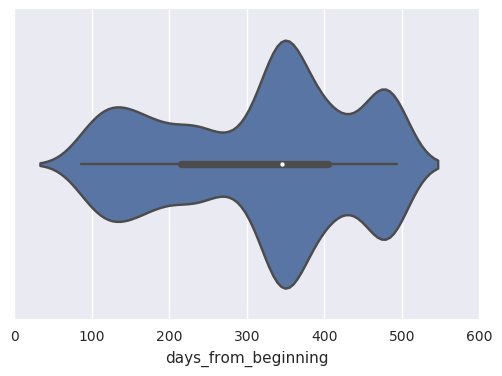

In [18]:
sns.violinplot(days)

In [21]:
days.describe()

count    2000.000000
mean      317.505000
std       121.431486
min        86.000000
25%       214.750000
50%       345.000000
75%       404.000000
max       493.000000
Name: days_from_beginning, dtype: float64

In [22]:
feather.write_dataframe(df_pays_fixed, 'data/df_pays_na.feather')

In [106]:
df_pays = feather.read_dataframe('data/df_pays_na.feather')

In [107]:
df_pays['dow'] = df_pays.day.dt.dayofweek
df_pays['is_weekend'] = df_pays.dow.isin([5, 6])
df_pays['month'] = df_pays.day.dt.month
df_pays['week'] = df_pays.day.dt.weekofyear

In [108]:
train_end = pd.to_datetime('2016-10-17')

In [126]:
def add_rolling_features(df_shop):
    shift = df_shop.pays_count.shift(14)
    df_shop['count_two_weeks_ago'] = shift

    for w in [1, 2, 4, 8]:
        rolling = shift.rolling(7 * w)
        df_shop['rolling_mean_%d' % w] = rolling.mean()
        df_shop['rolling_min_%d' % w] = rolling.min()
        df_shop['rolling_max_%d' % w] = rolling.max()
        df_shop['rolling_std_%d' % w] = rolling.std()

        for i in range(0, 7):
            idx = df_shop.dow == i
            rolling = shift[idx].rolling(w)
            df_shop.loc[idx, 'rolling_mean_%d_dow' % w] = rolling.mean()
            df_shop.loc[idx, 'rolling_min_%d_dow' % w] = rolling.min()
            df_shop.loc[idx, 'rolling_max_%d_dow' % w] = rolling.max()
            df_shop.loc[idx, 'rolling_std_%d_dow' % w] = rolling.std()

    return df_shop

In [127]:
def add_overall_trend_feature(df_train, df_val):
    y = df_train.pays_count
    not_null = ~y.isnull()

    x = df_train.days_from_beginning
    x_not_null = x[not_null].values.reshape(-1, 1)
    y = y[not_null].values
    lr = LinearRegression().fit(x_not_null, y)

    x = x.values.reshape(-1, 1)
    df_train['store_overall_trend'] = lr.predict(x)

    x_val = df_val.days_from_beginning.values.reshape(-1, 1)
    df_val['store_overall_trend'] = lr.predict(x_val)


def add_dow_trend_feature(df_train, df_val):
    df_train['store_dow_trend'] = np.nan
    df_val['store_dow_trend'] = np.nan

    for i in range(7):
        idx = (df_train.dow == i)

        y = df_train[idx].pays_count
        not_null = ~y.isnull()

        x = df_train[idx].days_from_beginning
        x_not_null = x[not_null].values.reshape(-1, 1)
        y = y[not_null].values
        lr = LinearRegression().fit(x_not_null, y)

        x = x.values.reshape(-1, 1)
        df_train.loc[idx, 'store_dow_trend'] = lr.predict(x)

        val_idx = (df_val.dow == i)
        x_val = df_val[val_idx].days_from_beginning.values.reshape(-1, 1)
        df_val.loc[val_idx, 'store_dow_trend'] = lr.predict(x_val)


def add_weekend_trend_feature(df_train, df_val):
    df_train['store_weekend_trend'] = np.nan
    df_val['store_weekend_trend'] = np.nan

    for i in [True, False]:
        idx = (df_train.is_weekend == i)

        y = df_train[idx].pays_count
        not_null = ~y.isnull()

        x = df_train[idx].days_from_beginning
        x_not_null = x[not_null].values.reshape(-1, 1)
        y = y[not_null].values
        lr = LinearRegression().fit(x_not_null, y)

        x = x.values.reshape(-1, 1)
        df_train.loc[idx, 'store_weekend_trend'] = lr.predict(x)

        val_idx = (df_val.is_weekend == i)
        x_val = df_val[val_idx].days_from_beginning.values.reshape(-1, 1)
        df_val.loc[val_idx, 'store_weekend_trend'] = lr.predict(x_val)    


def add_trend_features(df_train, df_val):
    add_overall_trend_feature(df_train, df_val)
    add_dow_trend_feature(df_train, df_val)
    add_weekend_trend_feature(df_train, df_val)

In [130]:
train_dfs = []
val_dfs = []

for i in tqdm(shops):
    df_shop = df_pays[df_pays.shop_id == i].copy()
    add_rolling_features(df_shop)

    df_train = df_shop[df_shop.day <= train_end].reset_index()
    df_val = df_shop[df_shop.day > train_end].reset_index()

    add_trend_features(df_train, df_val)
    
    train_dfs.append(df_train)
    val_dfs.append(df_val)

100%|██████████| 2000/2000 [10:18<00:00,  3.41it/s]


In [131]:
truncated_train_dfs = []

for df in train_dfs:
    truncated_train_dfs.append(df.iloc[7 * 4:])

In [132]:
df_train = pd.concat(truncated_train_dfs)
df_val = pd.concat(val_dfs)

In [136]:
len(df_train)

553010

In [138]:
for c in ['rolling_std_1_dow', 'rolling_mean_8', 'rolling_min_8', 
          'rolling_max_8', 'rolling_std_8']:
    del df_train[c], df_val[c]

In [142]:
df_train = df_train[~df_train.pays_count.isnull()]
df_val = df_val[~df_val.pays_count.isnull()]

In [143]:
to_exclude = {'pays_count', 'index', 'shop_id', 'day', 'days_from_beginning', 'month', 'week'}
features = sorted(set(df_train.columns) - to_exclude)
features

['count_two_weeks_ago',
 'dow',
 'is_weekend',
 'rolling_max_1',
 'rolling_max_1_dow',
 'rolling_max_2',
 'rolling_max_2_dow',
 'rolling_max_4',
 'rolling_max_4_dow',
 'rolling_max_8_dow',
 'rolling_mean_1',
 'rolling_mean_1_dow',
 'rolling_mean_2',
 'rolling_mean_2_dow',
 'rolling_mean_4',
 'rolling_mean_4_dow',
 'rolling_mean_8_dow',
 'rolling_min_1',
 'rolling_min_1_dow',
 'rolling_min_2',
 'rolling_min_2_dow',
 'rolling_min_4',
 'rolling_min_4_dow',
 'rolling_min_8_dow',
 'rolling_std_1',
 'rolling_std_2',
 'rolling_std_2_dow',
 'rolling_std_4',
 'rolling_std_4_dow',
 'rolling_std_8_dow',
 'store_dow_trend',
 'store_overall_trend',
 'store_weekend_trend']

In [145]:
X_train = df_train[features].values
y_train = df_train.pays_count.values

In [148]:
X_val = df_val[features].values
y_val = df_val.pays_count.values

In [149]:
xgb_pars = {
    'eta': 0.1,
    'gamma': 0,
    'max_depth': 6,
    'min_child_weight': 1,
    'max_delta_step': 0,
    'subsample': 1,
    'colsample_bytree': 1,
    'colsample_bylevel': 1,
    'lambda': 1,
    'alpha': 0,
    'tree_method': 'approx',
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'nthread': 8,
    'seed': 42,
    'silent': 1
}

n_estimators = 120

In [150]:
import xgboost as xgb

In [151]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features, missing=np.nan)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features, missing=np.nan)
watchlist = [(dtrain, 'train'), (dval, 'val')]

model = xgb.train(xgb_pars, dtrain, num_boost_round=n_estimators, verbose_eval=10, evals=watchlist)

[0]	train-rmse:162.335	val-rmse:189.995
[10]	train-rmse:81.9643	val-rmse:92.2384
[20]	train-rmse:64.1826	val-rmse:73.632
[30]	train-rmse:60.9483	val-rmse:71.7141
[40]	train-rmse:60.0261	val-rmse:70.8476
[50]	train-rmse:59.7006	val-rmse:70.3588
[60]	train-rmse:59.5151	val-rmse:70.089
[70]	train-rmse:59.3568	val-rmse:69.5506
[80]	train-rmse:59.2577	val-rmse:69.2532
[90]	train-rmse:59.052	val-rmse:69.1407
[100]	train-rmse:58.9512	val-rmse:69.102
[110]	train-rmse:58.7318	val-rmse:69.196


In [153]:
y_pred = model.predict(dval)

In [159]:
evaluation_metric(y_val, y_pred)

0.12009063904171892

In [154]:
evaluation_metric(y_val, y_pred)

0.12052107143971791

In [155]:
scores = model.get_score(importance_type='gain')
sorted(scores.items(), key=lambda x: -x[1])

[('store_dow_trend', 73868822.9679056),
 ('store_weekend_trend', 13470613.556506848),
 ('rolling_max_2', 6500393.544965219),
 ('rolling_std_8_dow', 5339033.290344827),
 ('rolling_max_1', 3619389.439797101),
 ('rolling_min_2_dow', 2737645.460909091),
 ('rolling_std_1', 2475979.538392857),
 ('rolling_max_4', 2122051.7500582864),
 ('store_overall_trend', 1953567.0144888882),
 ('rolling_min_2', 1898065.6659437506),
 ('count_two_weeks_ago', 1745369.359213295),
 ('rolling_max_2_dow', 1712617.9136458328),
 ('rolling_std_4', 1471598.4237078652),
 ('rolling_mean_2_dow', 1248106.2088235293),
 ('rolling_max_8_dow', 1101077.3361256544),
 ('rolling_min_4', 1071002.8357207212),
 ('rolling_std_4_dow', 925254.6925000001),
 ('rolling_min_4_dow', 798980.1672413793),
 ('rolling_min_1', 743627.956970874),
 ('dow', 660700.592938628),
 ('rolling_min_8_dow', 656938.250980392),
 ('rolling_std_2', 552633.0988505747),
 ('rolling_mean_1', 440244.8805298012),
 ('rolling_mean_2', 392393.4374807692),
 ('rolling_mea

In [259]:
evaluation_metric(y_val, y_pre)

0.095394389645392236